## #使用mindspore框架

In [1]:

import mindspore
from mindspore import nn
from mindspore import ops
from mindspore.dataset import vision, transforms
######使用MnistDataset数据集
from mindspore.dataset import MnistDataset

### 下载数据集

In [2]:
# 使用download下载
# from download import download

# url = "https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/" \
#       "notebook/datasets/MNIST_Data.zip"
# path = download(url, "./", kind="zip", replace=True)


In [3]:

train_dataset= MnistDataset('MNIST_Data/train')
test_dataset = MnistDataset('MNIST_Data/test')

In [4]:
# 这里容易出错，与经典的Lenet-5一样，数据集读取后图片大小为28*28
# 但是Lenet-5的第一层卷积层输入为32*32，数据处理需要Resize([32,32])

for data in test_dataset.create_dict_iterator():
    print(f"Shape of image [N, C, H, W]: {data['image'].shape} {data['image'].dtype}")
    print(f"Shape of label: {data['label'].shape} {data['label'].dtype}")
    break

Shape of image [N, C, H, W]: (28, 28, 1) UInt8
Shape of label: () UInt32


### #数据处理

In [5]:
# 数据处理包括归一化，管道化
def datapipe(dataset, batch_size):
    image_transforms = [
        #         处理数据将图片大小调整为32*32
        vision.Resize([32,32]), 
        #         归一化处理
        vision.Rescale(1.0 / 255.0, 0),
        #         管道化处理
        vision.Normalize(mean=(0.1307,), std=(0.3081,)),

        #         调换维度(32,32,1)->(1,32,32)记不住可以看函数名
        vision.HWC2CHW()
    ]
    label_transform = transforms.TypeCast(mindspore.int32)

    dataset = dataset.map(image_transforms, 'image')
    dataset = dataset.map(label_transform, 'label')
#     设置batch_size
    dataset = dataset.batch(batch_size)
    return dataset

In [6]:
# batch_size设置为64,
train_dataset = datapipe(train_dataset, 64)
test_dataset = datapipe(test_dataset, 64)

In [7]:
# 查看此时的图片的大小调整为32*32了

for image, label in test_dataset.create_tuple_iterator():
    print(f"Shape of image [N, C, H, W]: {image.shape} {image.dtype}")
    print(f"Shape of label: {label.shape} {label.dtype}")
    break


Shape of image [N, C, H, W]: (64, 1, 32, 32) Float32
Shape of label: (64,) Int32


In [8]:
from mindspore.nn import CellList
class LeNet5(nn.Cell):
    """
    Lenet网络结构
    """
    def __init__(self, num_class=10, num_channel=1):
        super(LeNet5, self).__init__()
        # 定义所需要的运算
        self.conv1 = nn.Conv2d(num_channel, 6, 5, pad_mode='valid')
        self.conv2 = nn.Conv2d(6, 16, 5, pad_mode='valid')
        self.fc1 = nn.Dense(16 * 5 * 5, 120)
        self.fc2 = nn.Dense(120, 84)
        self.fc3 = nn.Dense(84, num_class)
        self.relu = nn.ReLU()
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
      

    def construct(self, x):
        # 使用定义好的运算构建前向网络
        x = self.conv1(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

In [9]:
lenet5=LeNet5()
# 定义损失函数
net_loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')   

# 定义优化器      
net_opt = nn.Momentum(lenet5.trainable_params(), learning_rate=0.01, momentum=0.9)

### 自定义train函数

In [10]:
from mindspore import ops
from mindspore.dataset import vision, transforms
def train(model, dataset, loss_fn, optimizer):
    # Define forward function
    def forward_fn(data, label):
        logits = model(data)
        loss = loss_fn(logits, label)
        return loss, logits

    # Get gradient function
    grad_fn = ops.value_and_grad(forward_fn, None, optimizer.parameters, has_aux=True)

    # Define function of one-step training
    def train_step(data, label):
        (loss, _), grads = grad_fn(data, label)
        loss = ops.depend(loss, optimizer(grads))
        return loss

    size = dataset.get_dataset_size()
    model.set_train()
    for batch, (data, label) in enumerate(dataset.create_tuple_iterator()):
        loss = train_step(data, label)

        if batch % 100 == 0:
            loss, current = loss.asnumpy(), batch
            print(f"loss: {loss:>7f}  [{current:>3d}/{size:>3d}]")

### 测试函数

In [11]:
def test(model, dataset, loss_fn):
    num_batches = dataset.get_dataset_size()
#     model.set_train(False)
    total, test_loss, correct = 0, 0, 0
    for data, label in dataset.create_tuple_iterator():
        pred = model(data)
        total += len(data)
#         对比预测和实际求平均
        test_loss += loss_fn(pred, label).asnumpy()
        correct += (pred.argmax(1) == label).asnumpy().sum()
    test_loss /= num_batches
    correct /= total
    print(f"Test: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [12]:
# epochs = 10
# for t in range(epochs):
#     print(f"Epoch {t+1}\n-------------------------------")
#     train(model, train_dataset, net_loss, net_opt)
#     test(model, test_dataset, net_loss)
# print("初次训练完成!")

In [13]:
# from  mindspore import save_checkpoint
# # 保存模型----直接保存训练完的模型
# mindspore.save_checkpoint(model,"model.ckpt")
# print("-----------直接保存模型成功")

In [12]:
# 重新定义损失函数
net_loss_third = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')   

# 重新定义优化器      
net_opt_third= nn.Momentum(lenet5.trainable_params(), learning_rate=0.02, momentum=0.9)

In [13]:
# 初始化网咯模型
# lenet5 =LeNet5()
parm_dict=mindspore.load_checkpoint("model.ckpt")
mindspore.load_param_into_net(lenet5,parm_dict)

[]

### 训练过程中保存模型

In [16]:
# 训练过程中保存模型
# 了解callback
from  mindspore.train import Model
from mindspore.nn import Accuracy
from mindspore.train.callback import ModelCheckpoint, CheckpointConfig 
epoch_num=1
ckpt_config=CheckpointConfig(save_checkpoint_steps=938,keep_checkpoint_max=100)
model_ckpt=ModelCheckpoint(prefix="lenet5",directory="./lenet5_2",config=ckpt_config)
model=Model(lenet5,loss_fn=net_loss_third,optimizer=net_opt_third,metrics={'acc', 'loss'})


In [17]:
train_dataset_second = MnistDataset('MNIST_Data/train')
train_dataset_second=datapipe(train_dataset_second,64)
test_dataset_second = MnistDataset('MNIST_Data/train')
test_dataset_second=datapipe(test_dataset_second,64)

In [18]:
# Model.train的损失函数监听器
from mindspore.train import LossMonitor

# 使用Model接口的train方法，设定callback保存与监听
model.train(epoch=epoch_num,train_dataset=train_dataset_second,callbacks=[model_ckpt,LossMonitor(100)])
# 模型验证调用Model接口eval验证
# model.eval()

epoch: 1 step: 100, loss is 0.030534179881215096
epoch: 1 step: 200, loss is 0.07314188778400421
epoch: 1 step: 300, loss is 0.10814066231250763
epoch: 1 step: 400, loss is 0.0035516030620783567
epoch: 1 step: 500, loss is 0.03470915928483009
epoch: 1 step: 600, loss is 0.06783783435821533
epoch: 1 step: 700, loss is 0.10278747975826263
epoch: 1 step: 800, loss is 0.06219031661748886
epoch: 1 step: 900, loss is 0.0025574974715709686


In [14]:
# 加载训练过的模型
from mindspore import load_checkpoint,load_param_into_net
model=LeNet5()
# 加载网络模型权重参数
parm_dict=mindspore.load_checkpoint("model.ckpt")
# 权重参数绑定网络模型
load_param_into_net(model,parm_dict)
print(model)
print("加载模型成功")

LeNet5<
  (conv1): Conv2d<input_channels=1, output_channels=6, kernel_size=(5, 5), stride=(1, 1), pad_mode=valid, padding=0, dilation=(1, 1), group=1, has_bias=False, weight_init=normal, bias_init=zeros, format=NCHW>
  (conv2): Conv2d<input_channels=6, output_channels=16, kernel_size=(5, 5), stride=(1, 1), pad_mode=valid, padding=0, dilation=(1, 1), group=1, has_bias=False, weight_init=normal, bias_init=zeros, format=NCHW>
  (fc1): Dense<input_channels=400, output_channels=120, has_bias=True>
  (fc2): Dense<input_channels=120, output_channels=84, has_bias=True>
  (fc3): Dense<input_channels=84, output_channels=10, has_bias=True>
  (relu): ReLU<>
  (max_pool2d): MaxPool2d<kernel_size=2, stride=2, pad_mode=VALID>
  (flatten): Flatten<>
  >
加载模型成功


In [20]:
# 用加载的模型继续训练
# 首先重新初始化损失函数和优化器，否则报错

In [15]:
# 重新定义损失函数
net_loss_second = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')   

# 重新定义优化器      
net_opt_second= nn.Momentum(model.trainable_params(), learning_rate=0.01, momentum=0.9)

In [16]:
epochs = 1
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(model, train_dataset, net_loss_second, net_opt_second)
    test(model, test_dataset, net_loss_second)
print("再次训练完成!")

Epoch 1
-------------------------------
loss: 0.013557  [  0/938]
loss: 0.000656  [100/938]
loss: 0.049677  [200/938]
loss: 0.068598  [300/938]
loss: 0.040679  [400/938]
loss: 0.022501  [500/938]
loss: 0.003258  [600/938]
loss: 0.076579  [700/938]
loss: 0.025600  [800/938]
loss: 0.028638  [900/938]
Test: 
 Accuracy: 98.5%, Avg loss: 0.049466 

再次训练完成!


In [17]:
# 模型再次训练完后，也可以预测数据
for data, label in test_dataset:
    pred = model(data)
    predicted = pred.argmax(1)
    print(f'Predicted: "{predicted[:10]}", Actual: "{label[:10]}"')
    break

Predicted: "[2 9 1 3 2 0 1 7 7 1]", Actual: "[2 9 1 3 3 0 1 7 7 1]"


## 内部测试抽取一张图片预测

In [18]:
import mindspore.dataset as ds
import os
import matplotlib.pyplot as plt
dataset_dir="MNIST_Data/test"
data=ds.MnistDataset(dataset_dir,usage='test',num_samples=1,shuffle=False)
# data_origin=data

In [19]:
# 此时取出的照片形状时(28,28,1)
for item in data.create_dict_iterator(output_numpy=True):
    image=item['image']
image.shape

(28, 28, 1)

### 绘制图形

In [20]:
# 绘制图形

def draw_data(data):
    for item in data.create_dict_iterator(num_epochs=1, output_numpy=True):
        image = item["image"]
        label = item["label"]
    plt.imshow(image.squeeze(2), cmap=plt.cm.gray)
    plt.title(label)
    plt.show()
    
# draw_data(data)


In [276]:
# 这个cell用于调试参看
# # data=datapipe(data,1)
# for item in datapipe(data,1).create_dict_iterator(num_epochs=1, output_numpy=True):
#     image=item['image']
    
# image.shape
# # draw_data(data_origin)

In [277]:
# 这个cell也是用于调试
# # 注意模型输入类型是Tensor
# from mindspore import Tensor
# for item in data:
#     image=item[0]
# print(Tensor(image))

In [21]:
import mindspore.dataset.vision
from mindspore.dataset.vision import Inter
import numpy as np

### 加载模型进行预测

Predicted: "7", Actual: "7"


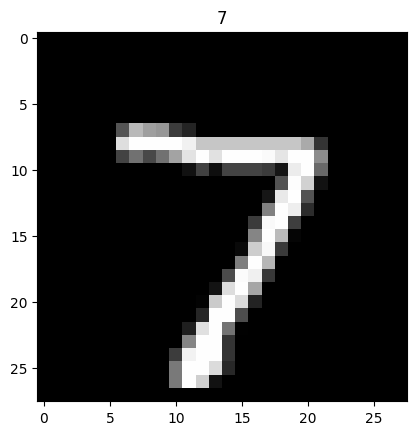

In [22]:
# 加载模型参数到网络中
from mindspore import Model
from mindspore import Tensor
param_dict = load_checkpoint("model.ckpt")
model = LeNet5()
load_param_into_net(model, param_dict)

# 定义测试数据集，batch_size设置为1，取出一张图片 
for item in datapipe(data,1):
    image=item[0]
    label=item[1]
output=model(Tensor(image))
predicted = np.argmax(output.asnumpy(), axis=1)
# 输出预测分类与实际分类
print(f'Predicted: "{predicted[0]}", Actual: "{label[0]}"')
draw_data(data)

In [23]:
mindspore.save_checkpoint(model,"model.ckpt")
print("保存成功")

保存成功


In [24]:
# 初始化网咯模型
lenet =LeNet5()
parm_dict=mindspore.load_checkpoint("model.ckpt")
mindspore.load_param_into_net(lenet,param_dict)
model=Model(lenet)

## 引入外部图片数据进行预测



In [6]:
![image.png].(img10/0.png)
![jupyter](./img10/1.png)
![jupyter](./img10/2.png)
![jupyter](./img10/3.png)
![jupyter](./img10/4.png)
![jupyter](./img10/5.png)
![jupyter](./img10/6.png)
![jupyter](./img10/7.png)
![jupyter](./img10/8.png)
![jupyter](./img10/9.png)

'[image.png].' is not recognized as an internal or external command,
operable program or batch file.
'[jupyter]' is not recognized as an internal or external command,
operable program or batch file.
'[jupyter]' is not recognized as an internal or external command,
operable program or batch file.
'[jupyter]' is not recognized as an internal or external command,
operable program or batch file.
'[jupyter]' is not recognized as an internal or external command,
operable program or batch file.
'[jupyter]' is not recognized as an internal or external command,
operable program or batch file.
'[jupyter]' is not recognized as an internal or external command,
operable program or batch file.
'[jupyter]' is not recognized as an internal or external command,
operable program or batch file.
'[jupyter]' is not recognized as an internal or external command,
operable program or batch file.
'[jupyter]' is not recognized as an internal or external command,
operable program or batch file.


In [25]:
import os
import PIL
import numpy as np
from PIL import Image
from PIL import ImageFilter
import PIL.ImageOps 
import matplotlib.pyplot as plt
from mindspore import Tensor

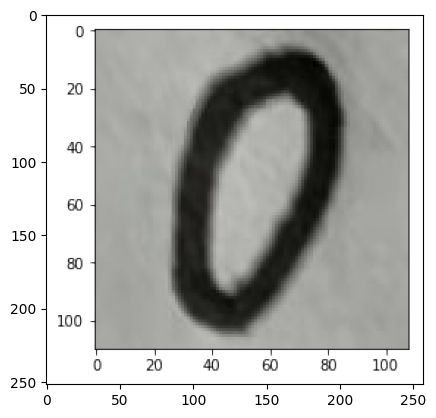

D:\Python\Anaconda\envs\mindspore-cp3.7\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  if sys.path[0] == "":


识别后预测数字:===>> "0", 实际数字是:==>>> "0"


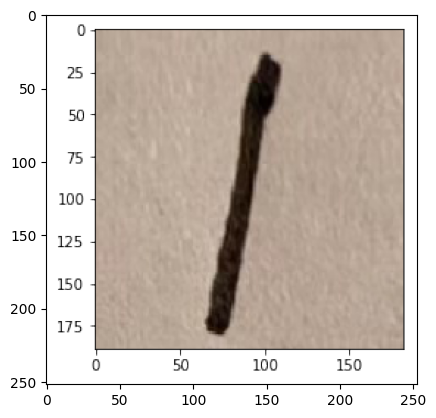

识别后预测数字:===>> "1", 实际数字是:==>>> "1"


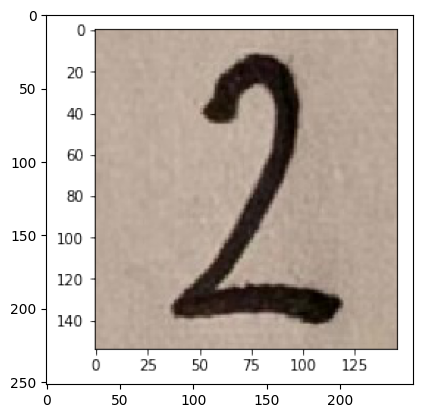

识别后预测数字:===>> "2", 实际数字是:==>>> "2"


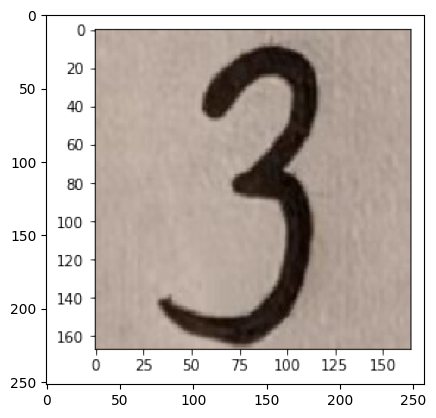

识别后预测数字:===>> "3", 实际数字是:==>>> "3"


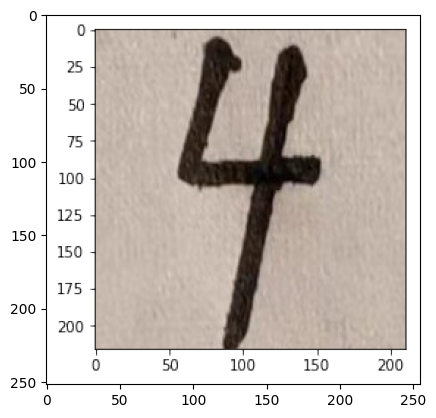

识别后预测数字:===>> "4", 实际数字是:==>>> "4"


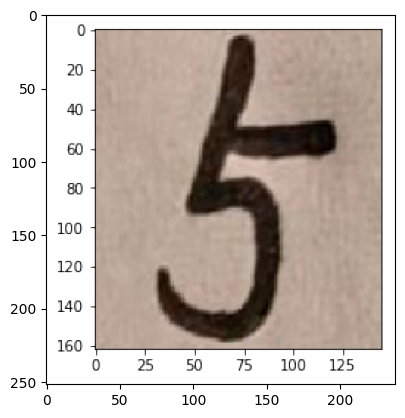

识别后预测数字:===>> "5", 实际数字是:==>>> "5"


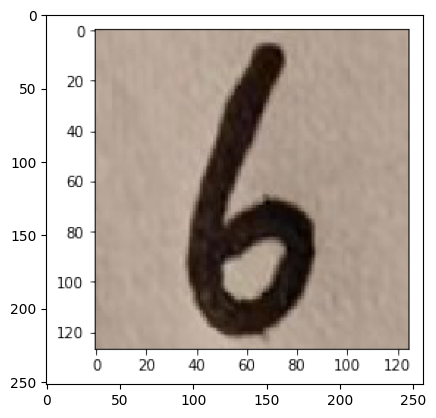

识别后预测数字:===>> "6", 实际数字是:==>>> "6"


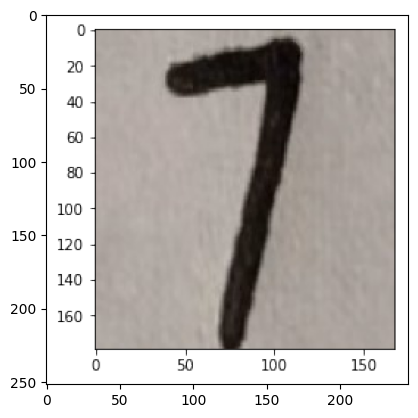

识别后预测数字:===>> "1", 实际数字是:==>>> "7"


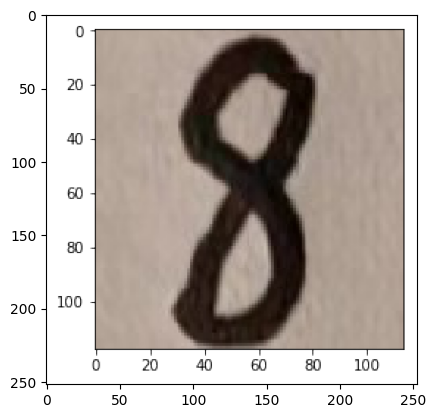

识别后预测数字:===>> "8", 实际数字是:==>>> "8"


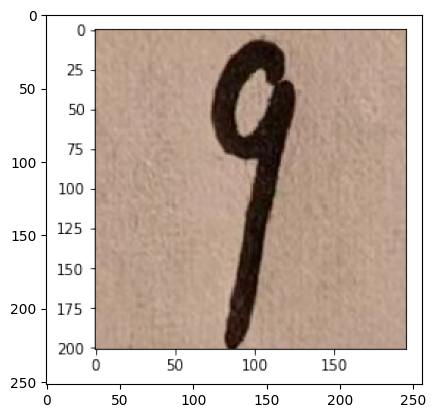

识别后预测数字:===>> "1", 实际数字是:==>>> "9"


In [26]:
#
number = 10
path=r"img10"
files = os .listdir(path)
for i in range(number):
    image_path = path+'/'+files[i]
    img = Image.open(image_path)
    plt.imshow(img)
    plt.show()
    img = img.convert("L")
#     对图片进行resize否则不能后面无法reshape成可输入的张量
    img = img.resize((32,32),Image.ANTIALIAS)
####   对图像进行处理，否则识别不出来
    img = img.filter(ImageFilter.DETAIL)
    img = img.filter(ImageFilter.SHARPEN)   
    img = PIL.ImageOps.invert(img)
####   数据预处理，归一化.....
    arr_img=np.array(img).reshape(1,1,32,32).astype(np.float32)
    arr_img=arr_img/255.0
####   数据转化为Tensor
    inputTensor=Tensor(arr_img)
    output=model.predict(inputTensor)
    predicted = np.argmax(output.asnumpy(), axis=1)
#####   进行预测
    print(f'识别后预测数字:===>> "{predicted[0]}", 实际数字是:==>>> "{files[i].split(".")[0]}"')

## 训练过程中保存模型，callback的学习

In [35]:
# 重新定义损失函数
net_loss_third = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')   

# 重新定义优化器      
net_opt_third= nn.Momentum(LeNet5().trainable_params(), learning_rate=0.02, momentum=0.9)

In [61]:
# 初始化网咯模型
lenet =LeNet5()
parm_dict1=mindspore.load_checkpoint("model.ckpt")
mindspore.load_param_into_net(lenet,parm_dict)

[]

In [ ]:
# 训练过程中保存模型
# 了解callback
from  mindspore.train import Model
from mindspore.nn import Accuracy
from mindspore.train.callback import ModelCheckpoint, CheckpointConfig 
epoch_num=10
ckpt_config=CheckpointConfig(save_checkpoint_steps=938,keep_checkpoint_max=100)
model_ckpt=ModelCheckpoint(prefix="lenet5",directory="./lenet5",config=ckpt_config)
model=Model(lenet5,loss_fn=net_loss_third,optimizer=net_opt_third,metrics={'acc', 'loss'})


In [ ]:
train_dataset_second = MnistDataset('MNIST_Data/train')
train_dataset_second=datapipe(train_dataset_second,64)

# 使用Model接口的train方法
model.train(epoch=10,train_dataset=train_dataset_second,callbacks=model_ckpt)
